In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from scipy.stats import gaussian_kde


# The file appears to be space/whitespace separated
# Using delimiter=r'\s+' to handle multiple spaces/tabs
info = pd.read_csv('info.txt', delimiter=r'\s+')

# Filter columns: keep 'runid' and columns starting with 'ocn.' but exclude 'ocean_fw'
ocn_columns = [col for col in info.columns if col.startswith('ocn.')]
columns_to_keep = ['runid'] + ocn_columns

# Remove 'ocean_fw' if it exists in the selected columns
if 'ocn.l_noise_fw' in columns_to_keep:
    columns_to_keep.remove('ocn.l_noise_fw')

# Select only the desired columns
params = info[columns_to_keep]

# Display the results
print("Original shape:", info.shape)
print("Filtered shape:", params.shape)
print("\nKept columns:")
print(params.columns.tolist())
print("\nFirst 5 rows of filtered data:")
print(params.head())

Original shape: (99, 8)
Filtered shape: (99, 7)

Kept columns:
['runid', 'ocn.diff_dia_min', 'ocn.drag_topo_fac', 'ocn.slope_max', 'ocn.diff_iso', 'ocn.diff_gm', 'ocn.diff_dia_max']

First 5 rows of filtered data:
   runid  ocn.diff_dia_min  ocn.drag_topo_fac  ocn.slope_max  ocn.diff_iso  \
0      1          0.000010           2.816063       0.001247   1615.606127   
1      2          0.000010           2.760967       0.000817   1440.298245   
2      3          0.000011           2.553815       0.001108   1648.789119   
3      4          0.000010           3.425434       0.000784   1373.056807   
4      5          0.000011           2.281333       0.001231   1309.914618   

   ocn.diff_gm  ocn.diff_dia_max  
0  1178.446903          0.000139  
1  1156.620678          0.000179  
2  1727.339243          0.000151  
3  1172.548331          0.000140  
4  1594.469916          0.000136  


In [2]:
# Basic descriptive statistics
print("\nDescriptive Statistics:")
print(params.describe())


Descriptive Statistics:
           runid  ocn.diff_dia_min  ocn.drag_topo_fac  ocn.slope_max  \
count  99.000000         99.000000          99.000000      99.000000   
mean   50.000000          0.000010           2.997310       0.001000   
std    28.722813          0.000001           0.436868       0.000146   
min     1.000000          0.000008           2.264693       0.000751   
25%    25.500000          0.000009           2.625165       0.000875   
50%    50.000000          0.000010           2.988873       0.000998   
75%    74.500000          0.000011           3.376068       0.001124   
max    99.000000          0.000012           3.749145       0.001247   

       ocn.diff_iso  ocn.diff_gm  ocn.diff_dia_max  
count     99.000000    99.000000         99.000000  
mean    1497.397723  1500.157923          0.000150  
std      216.836888   219.136266          0.000022  
min     1130.438668  1126.433930          0.000113  
25%     1312.015546  1313.820452          0.000132  
50%     

In [3]:
# Find all ocn_ts.nc files
model_files = []
run_labels = []

for run_id in range(100):
    file_path = f"{run_id}/ocn_ts.nc"
    if os.path.exists(file_path):
        model_files.append(file_path)
        run_labels.append(str(run_id))


## Simpler summary statistics

In [4]:
import numpy as np

def compute_simple_summary_stats(amoc_data, time_data=None, 
                                remove_spinup=False, spinup_fraction=0.1, n_bins=10):
    """
    Compute simple summary statistics for AMOC time series.
    
    Parameters:
    -----------
    amoc_data : array-like
        AMOC strength time series
    time_data : array-like, optional
        Time values (if None, assumes uniform spacing)
    remove_spinup : bool
        Whether to remove initial spinup period
    spinup_fraction : float
        Fraction of data to remove as spinup (default 0.1 = 10%)
    
    Returns:
    --------
    dict : Summary statistics
    """
    
    amoc_data = np.asarray(amoc_data)
    
    # Remove spinup if requested
    if remove_spinup:
        start_idx = int(len(amoc_data) * spinup_fraction)
        amoc_data = amoc_data[start_idx:]
    
    # Define fixed bins for consistency across all simulations
    bins = np.linspace(0, 35, n_bins+1)  # 10 bins: [0-3], [3-6], ..., [27-30]
    
    # Calculate bin frequencies for ML emulator
    bin_counts, _ = np.histogram(amoc_data, bins=bins)
    bin_frequencies = bin_counts / len(amoc_data)  # Normalize to [0,1]
    
    # Simplified statistics
    stats = {
        'mean': np.mean(amoc_data),
        'std': np.std(amoc_data),
        'q25': np.percentile(amoc_data, 25),
        'q75': np.percentile(amoc_data, 75),
        'bin_frequencies': bin_frequencies,
    }
    
    return stats

# Helper function to get bins for plotting
def get_amoc_bins(n_bins):
    """Return the standard AMOC bins used across all functions."""
    return np.linspace(0, 35, n_bins+1)

In [5]:
# Default run
default_file = "../default_long_run/ocn_ts.nc"
ds_default = xr.open_dataset(default_file)
amoc_default = ds_default.amoc26N.values
time_default = ds_default.time.values
ds_default.close()

# Compute default summary statistics
default_stats = compute_simple_summary_stats(amoc_default, time_default)
print(f"Default stats computed: {list(default_stats.keys())}")

print(f"Number of ensemble files: {len(model_files)}")

# Ensemble runs
ensemble_stats = []
for i, file in enumerate(model_files):
    ds = xr.open_dataset(file)
    amoc = ds.amoc26N.values
    time = ds.time.values
    ds.close()
    
    stats = compute_simple_summary_stats(amoc, time)
    ensemble_stats.append(stats)

print(f"Total ensemble stats computed: {len(ensemble_stats)}")
print(f"Each run has {len(ensemble_stats[0])} summary statistics")

Default stats computed: ['mean', 'std', 'q25', 'q75', 'bin_frequencies']
Number of ensemble files: 99
Total ensemble stats computed: 99
Each run has 5 summary statistics


In [6]:
def plot_amoc_ensemble_simple(ensemble_stats, model_files, amoc_default, default_stats, 
                             n_runs=None, figsize_per_run=3, n_bins=10):
    """
    Plot AMOC time series and histograms for ensemble runs.
    
    Parameters:
    -----------
    ensemble_stats : list
        List of stats dictionaries from compute_simple_summary_stats
    model_files : list
        List of file paths for ensemble runs
    amoc_default : array-like
        Default/reference AMOC time series
    default_stats : dict
        Stats dictionary for default run
    n_runs : int, optional
        Number of runs to plot (if None, plots all)
    figsize_per_run : float
        Figure height per run in inches
    """
    
    if n_runs is None:
        n_runs = len(ensemble_stats)
    
    fig, axes = plt.subplots(n_runs, 2, figsize=(12, figsize_per_run * n_runs), 
                            gridspec_kw={'width_ratios': [3, 2]})
    
    # Handle single run case
    if n_runs == 1:
        axes = [axes]
    
    for i, (stats, file) in enumerate(zip(ensemble_stats[:n_runs], model_files[:n_runs])):
        ds = xr.open_dataset(file)
        amoc = ds.amoc26N.values
        ds.close()
        
        # ----------------------------
        # 1. Time series plot
        # ----------------------------
        axes[i][0].plot(amoc, color='darkblue', alpha=0.8, label='Ensemble')
        axes[i][0].plot(amoc_default, color='lightcoral', alpha=0.8, label='Default')
        
        # Add horizontal lines for key statistics
        axes[i][0].axhline(stats['mean'], color='darkblue', linestyle='-', alpha=0.3, label='Mean (Ens)')
        axes[i][0].axhline(default_stats['mean'], color='lightcoral', linestyle='-', alpha=0.3, label='Mean (Def)')
        axes[i][0].axhline(stats['q25'], color='darkblue', linestyle='--', alpha=0.3)
        axes[i][0].axhline(stats['q75'], color='darkblue', linestyle='--', alpha=0.3)
        
        axes[i][0].set_ylabel('AMOC (Sv)')
        axes[i][0].set_xlabel('Time')
        axes[i][0].set_title(f'AMOC Time Series - Run {i+1}')
        axes[i][0].legend()
        axes[i][0].grid(alpha=0.3)
        
        # Add summary stats text box
        stats_text = (
            f"Mean: {stats['mean']:.1f} Sv (Def: {default_stats['mean']:.1f})\n"
            f"Std: {stats['std']:.1f} Sv (Def: {default_stats['std']:.1f})\n"
            f"Q25-Q75: {stats['q25']:.1f}-{stats['q75']:.1f} Sv\n"
        )
        
        axes[i][0].text(
            0.98, 0.02, stats_text,
            transform=axes[i][0].transAxes,
            fontsize=8, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
        )
        
        # ----------------------------
        # 2. Histogram plot (bins defined in plotting function)
        # ----------------------------
        # Define bins in plotting function for flexibility
        bins = get_amoc_bins(n_bins)
        
        # Plot histograms - matplotlib calculates frequencies automatically
        axes[i][1].hist(amoc, bins=bins, alpha=0.7, color='darkblue', 
                       label='Ensemble', density=True, edgecolor='black')
        axes[i][1].hist(amoc_default, bins=bins, alpha=0.5, color='lightcoral', 
                       label='Default', density=True, edgecolor='black')
        
        # Add vertical lines for key statistics
        axes[i][1].axvline(stats['mean'], color='darkblue', linestyle='-', alpha=0.8, label='Mean (Ens)')
        axes[i][1].axvline(default_stats['mean'], color='lightcoral', linestyle='-', alpha=0.8, label='Mean (Def)')
        axes[i][1].axvline(stats['q25'], color='darkblue', linestyle='--', alpha=0.7, label='Q25/Q75 (Ens)')
        axes[i][1].axvline(stats['q75'], color='darkblue', linestyle='--', alpha=0.7)
        
        axes[i][1].set_xlabel('AMOC (Sv)')
        axes[i][1].set_ylabel('Density')
        axes[i][1].set_title(f'AMOC Distribution - Run {i+1}')
        axes[i][1].legend()
        axes[i][1].grid(alpha=0.3)
        axes[i][1].set_xlim(0, 35)
    
    plt.tight_layout()
    plt.show()

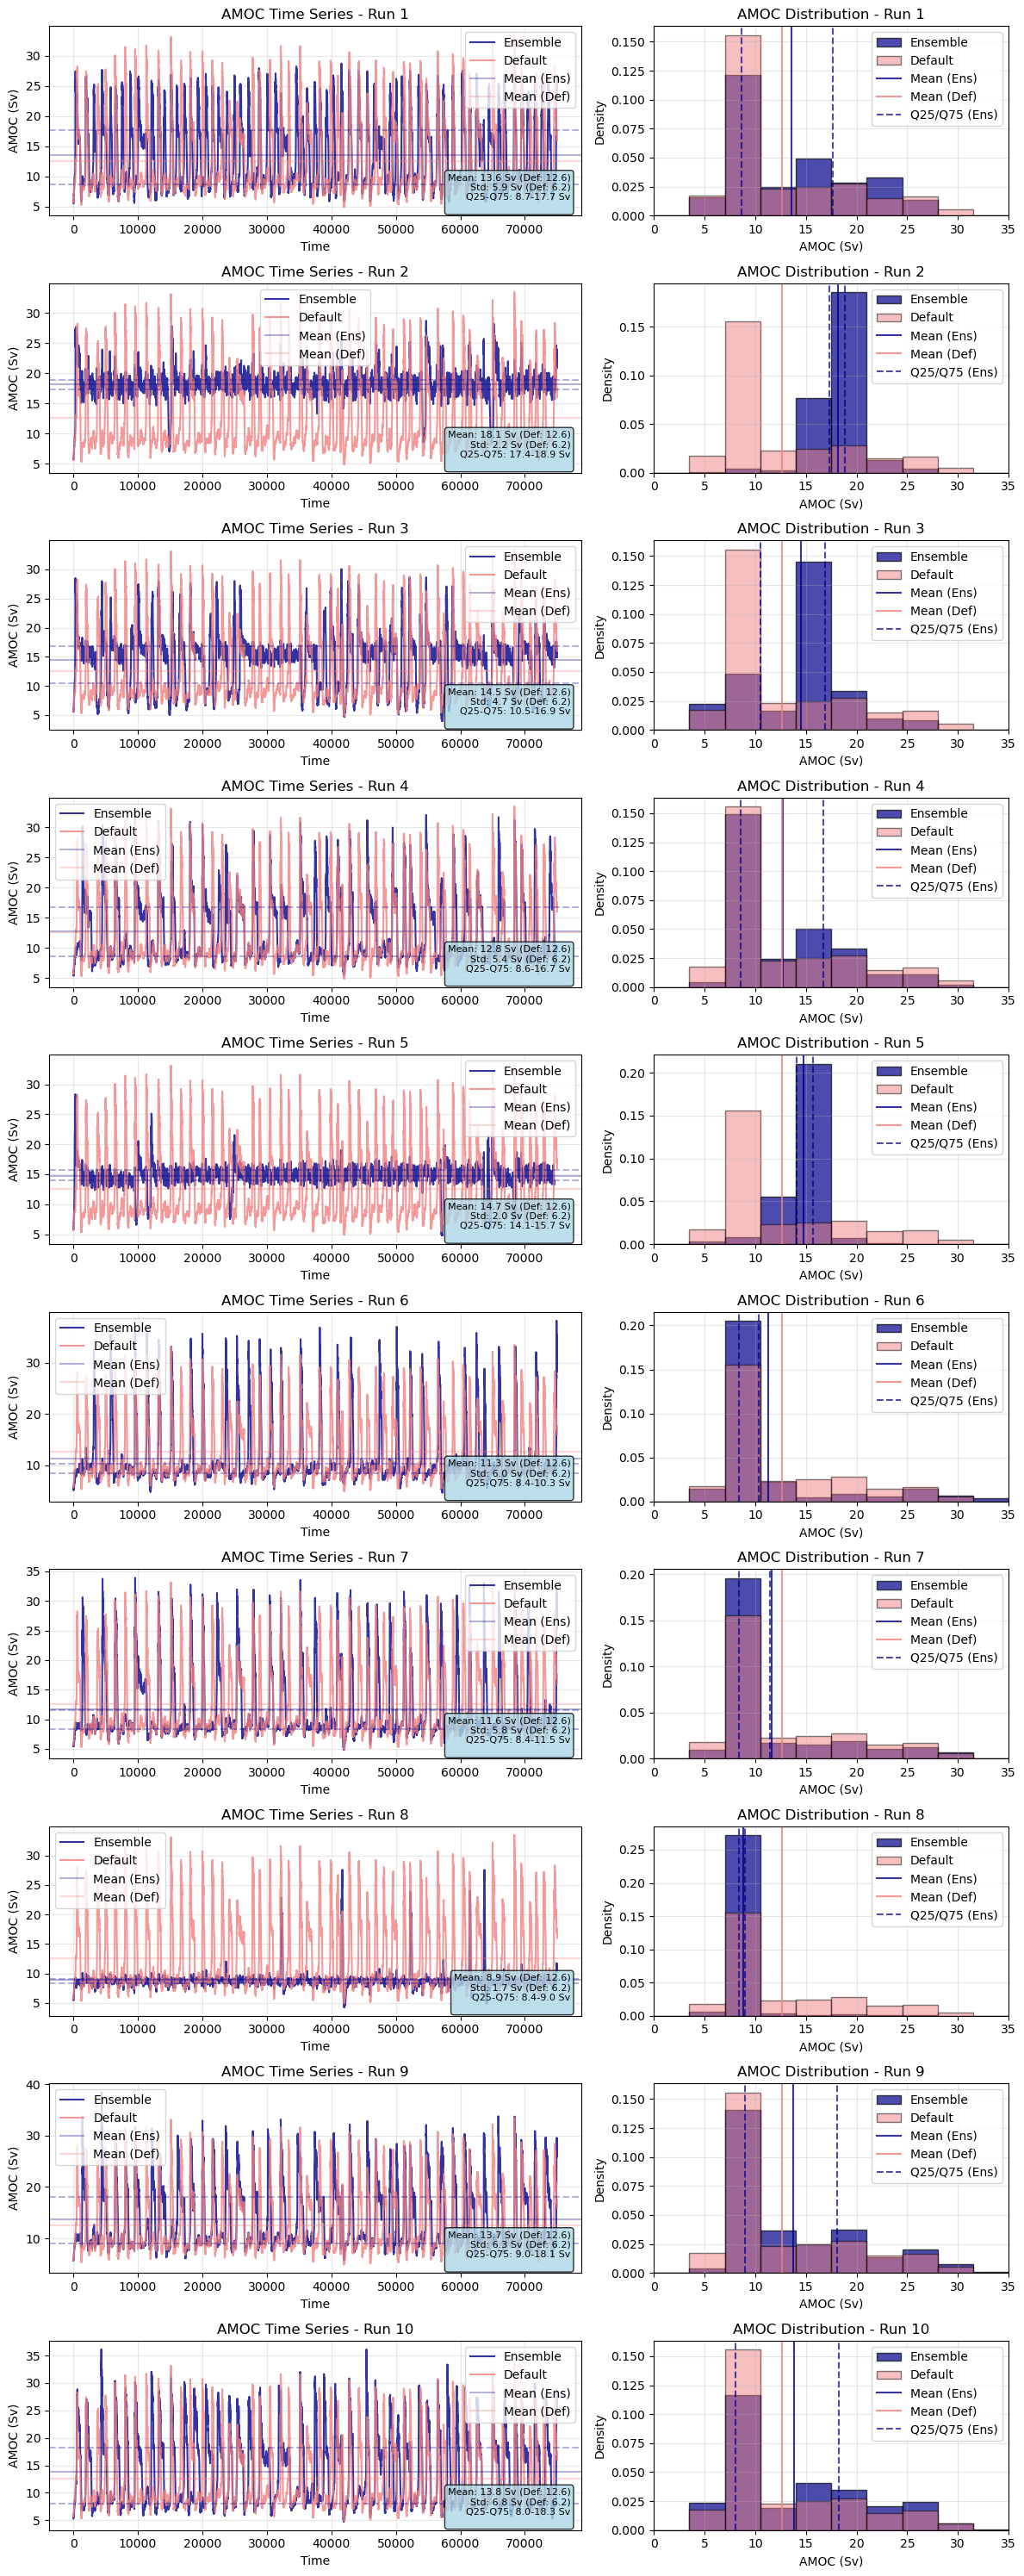

In [7]:
plot_amoc_ensemble_simple(ensemble_stats, model_files, amoc_default, default_stats, 
                             n_runs=10, figsize_per_run=3)

In [8]:
class GPEmulatorBins:
    def __init__(self, kernel=None, scaler_X=None, scaler_y=None):
        """
        GP emulator that predicts bin frequencies and other summary statistics.
        
        Parameters
        ----------
        kernel : GP kernel
            Kernel for the GP. If None, uses RBF + WhiteKernel
        scaler_X : scaler for input features
            If None, uses StandardScaler
        scaler_y : scaler for output features  
            If None, uses StandardScaler
        """
        self.kernel = kernel if kernel is not None else RBF(1.0) + WhiteKernel(1e-6)
        self.scaler_X = scaler_X if scaler_X is not None else StandardScaler()
        self.scaler_y = scaler_y if scaler_y is not None else StandardScaler()
        self.gp_model = None
        self.is_fitted = False
        self.n_bins = None
        self.n_other_stats = None
        
    def fit(self, X, Y, bin_frequencies):
        """
        Fit the GP emulator.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_parameters)
            Input parameters
        Y : array-like, shape (n_samples, n_other_summary_stats)
            Other summary statistics (mean, std, q25, q75)
        bin_frequencies : array-like, shape (n_samples, n_bins)
            Bin frequencies for each sample
        """
        # Store dimensions
        self.n_bins = bin_frequencies.shape[1]
        self.n_other_stats = Y.shape[1]
        
        # Combine bin frequencies and other summary stats
        Y_full = np.hstack([bin_frequencies, Y])
        
        # Scale inputs and outputs
        X_scaled = self.scaler_X.fit_transform(X)
        Y_scaled = self.scaler_y.fit_transform(Y_full)
        
        # Fit single multi-output GP (captures correlations between outputs)
        self.gp_model = GaussianProcessRegressor(
            kernel=self.kernel, 
            normalize_y=True,
            n_restarts_optimizer=3
        )
        self.gp_model.fit(X_scaled, Y_scaled)
        self.is_fitted = True
        
    def predict(self, X_new, return_std=False):
        """
        Predict bin frequencies and other summary stats for new inputs.
        
        Parameters
        ----------
        X_new : array-like, shape (n_samples, n_parameters)
            New input parameters
        return_std : bool
            Whether to return uncertainties
        
        Returns
        -------
        bin_frequencies_pred : array, shape (n_samples, n_bins)
            Predicted bin frequencies
        Y_pred : array, shape (n_samples, n_other_summary_stats)
            Predicted other summary statistics
        bin_frequencies_std : array, optional, shape (n_samples, n_bins)
            Uncertainty in bin frequencies
        Y_std : array, optional, shape (n_samples, n_other_summary_stats)
            Uncertainty in other summary statistics
        """
        if not self.is_fitted:
            raise RuntimeError("GPEmulatorBins must be fitted first.")
        
        X_scaled = self.scaler_X.transform(X_new)
        
        # Predict with GP
        if return_std:
            mean_scaled, std_scaled = self.gp_model.predict(X_scaled, return_std=True)
        else:
            mean_scaled = self.gp_model.predict(X_scaled)
            std_scaled = None
        
        # Inverse scaling
        mean_full = self.scaler_y.inverse_transform(mean_scaled)
        
        if return_std and std_scaled is not None:
            std_full = std_scaled * self.scaler_y.scale_
        else:
            std_full = None
        
        # Split bin frequencies and other summary stats
        bin_frequencies_pred = mean_full[:, :self.n_bins]
        Y_pred = mean_full[:, self.n_bins:]
        
        # Ensure bin frequencies are non-negative and sum to 1
        bin_frequencies_pred = self._normalize_bin_frequencies(bin_frequencies_pred)
        
        if return_std and std_full is not None:
            bin_frequencies_std = std_full[:, :self.n_bins]
            Y_std = std_full[:, self.n_bins:]
            
            return bin_frequencies_pred, Y_pred, bin_frequencies_std, Y_std
        else:
            return bin_frequencies_pred, Y_pred
    
    def _normalize_bin_frequencies(self, bin_frequencies):
        """
        Ensure bin frequencies are non-negative and sum to 1.
        """
        # Clip negative values to 0
        bin_frequencies = np.clip(bin_frequencies, 0, None)
        
        # Normalize each row to sum to 1
        row_sums = bin_frequencies.sum(axis=1, keepdims=True)
        # Avoid division by zero
        row_sums = np.where(row_sums == 0, 1, row_sums)
        bin_frequencies = bin_frequencies / row_sums
        
        return bin_frequencies
    
    def score(self, X_test, Y_test, bin_frequencies_test):
        """
        Compute R² score for the model predictions.
        
        Returns
        -------
        scores : dict
            R² scores for bin frequencies and other statistics
        """
        if not self.is_fitted:
            raise RuntimeError("GPEmulatorBins must be fitted first.")
        
        bin_frequencies_pred, Y_pred = self.predict(X_test, return_std=False)
        
        from sklearn.metrics import r2_score
        
        scores = {
            'bin_frequencies_r2': r2_score(bin_frequencies_test, bin_frequencies_pred),
            'other_stats_r2': r2_score(Y_test, Y_pred),
            'overall_r2': r2_score(
                np.hstack([bin_frequencies_test, Y_test]), 
                np.hstack([bin_frequencies_pred, Y_pred])
            )
        }
        
        return scores

Training on 99 runs with 6 parameters
Each distribution has 10 bins
Emulator fitted!
Predicted mean: 12.5 Sv (true: 12.6)
Predicted std:  6.0 Sv (true: 6.2)


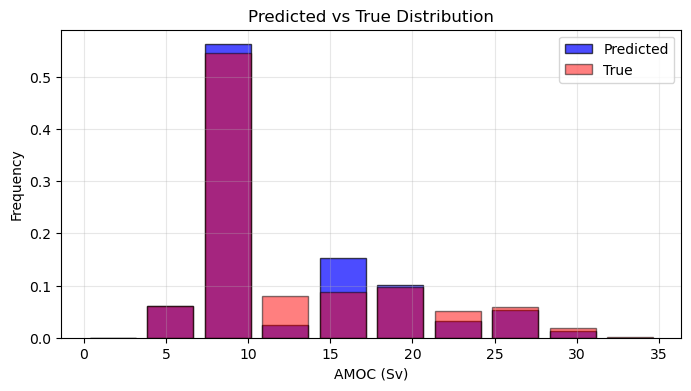

In [9]:
# ----------------------------
# 1. Prepare data
# ----------------------------
param_cols = ['ocn.diff_dia_min', 'ocn.drag_topo_fac', 'ocn.slope_max',
              'ocn.diff_iso', 'ocn.diff_gm', 'ocn.diff_dia_max']
X = params[param_cols].values
bin_frequencies = np.array([s['bin_frequencies'] for s in ensemble_stats])
other_stats = np.array([[s['mean'], s['std'], s['q25'], s['q75']] 
                       for s in ensemble_stats])

print(f"Training on {X.shape[0]} runs with {X.shape[1]} parameters")
print(f"Each distribution has {bin_frequencies.shape[1]} bins")

# ----------------------------
# 2. Fit emulator
# ----------------------------
gp_emul = GPEmulatorBins()
gp_emul.fit(X, other_stats, bin_frequencies)
print("Emulator fitted!")

# ----------------------------
# 3. Make prediction for default parameters
# ----------------------------
X_default = np.array([[1e-05, 3.0, 0.001, 1500, 1500, 0.00015]])
bin_pred, stats_pred = gp_emul.predict(X_default, return_std=False)

print(f"Predicted mean: {stats_pred[0,0]:.1f} Sv (true: {default_stats['mean']:.1f})")
print(f"Predicted std:  {stats_pred[0,1]:.1f} Sv (true: {default_stats['std']:.1f})")

# ----------------------------
# 4. Histogram plot
# ----------------------------
bins = get_amoc_bins(10)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

plt.figure(figsize=(8, 4))
plt.bar(bin_centers, bin_pred[0], width=bin_width*0.8, alpha=0.7, color='blue', 
        label='Predicted', edgecolor='black')
plt.bar(bin_centers, default_stats['bin_frequencies'], width=bin_width*0.8, alpha=0.5, 
        color='red', label='True', edgecolor='black')
plt.xlabel('AMOC (Sv)')
plt.ylabel('Frequency')
plt.title('Predicted vs True Distribution')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Train size: 79, Test size: 20
GP emulator fitted on training set.
Bin frequencies RMSE: 0.0740
mean RMSE: 0.5424
std RMSE: 0.9725
q25 RMSE: 1.6468
q75 RMSE: 1.7150


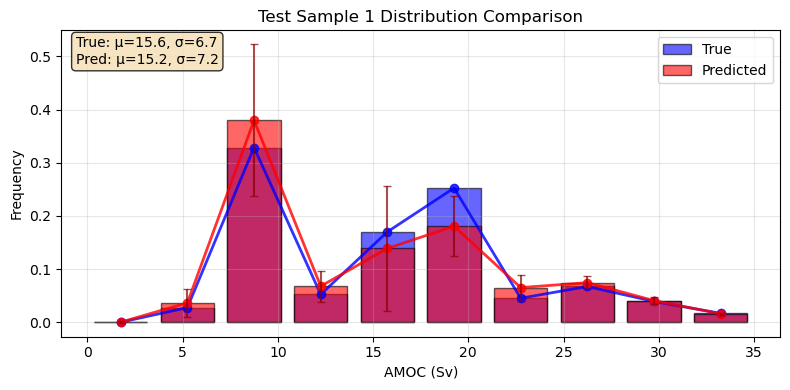

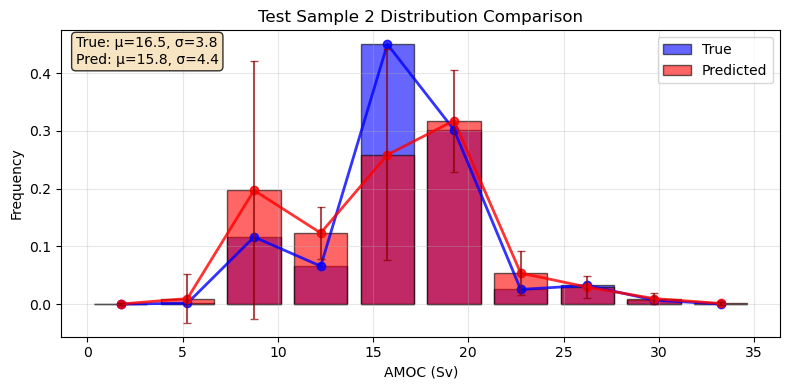

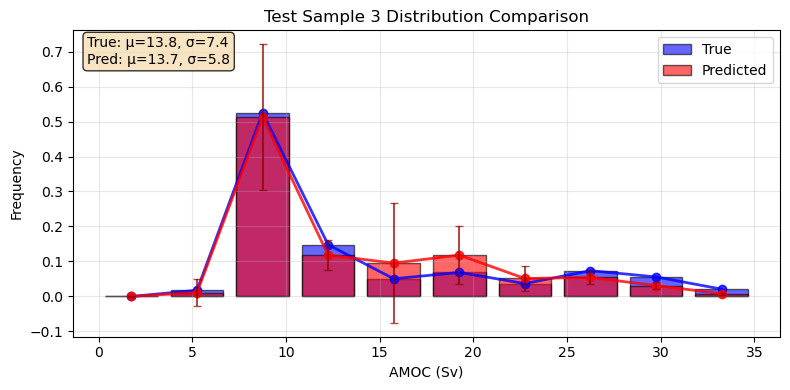

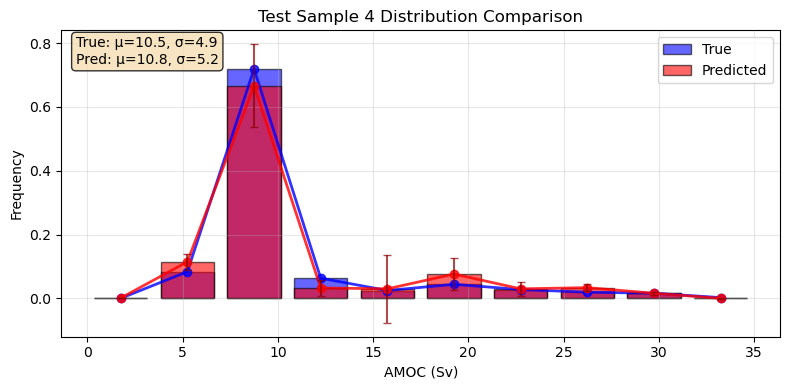

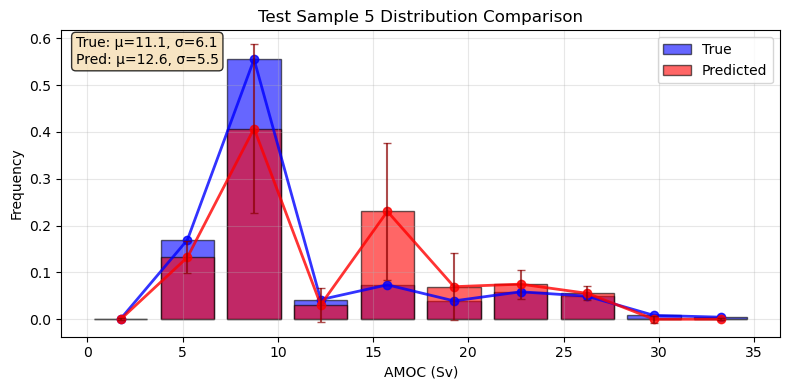

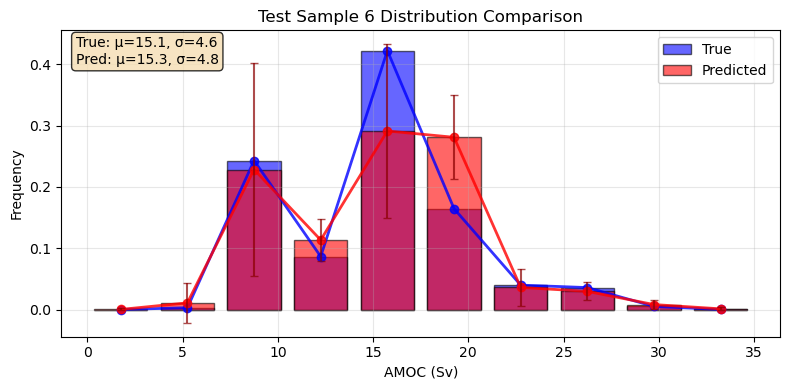

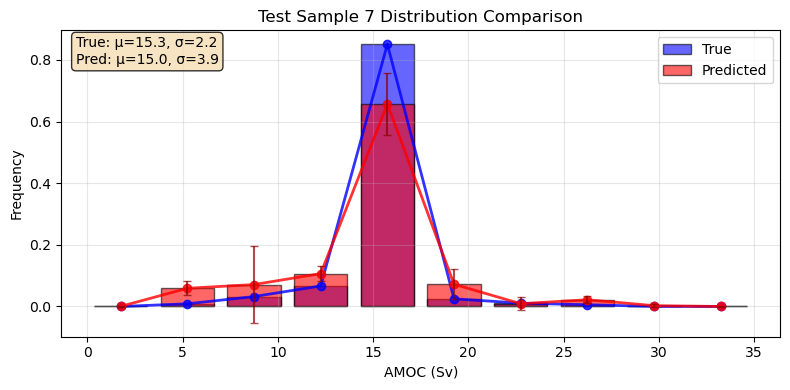

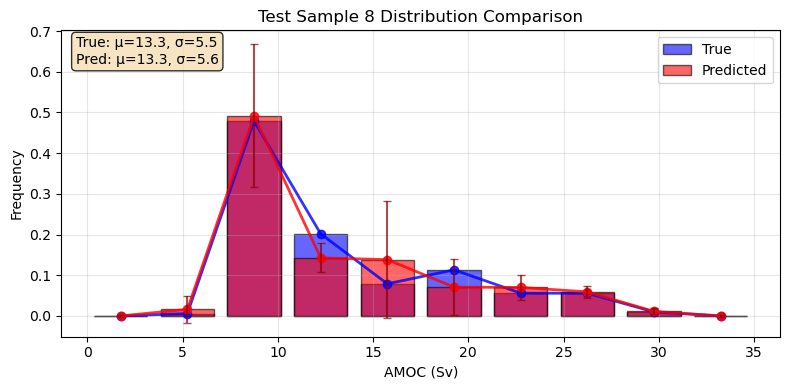

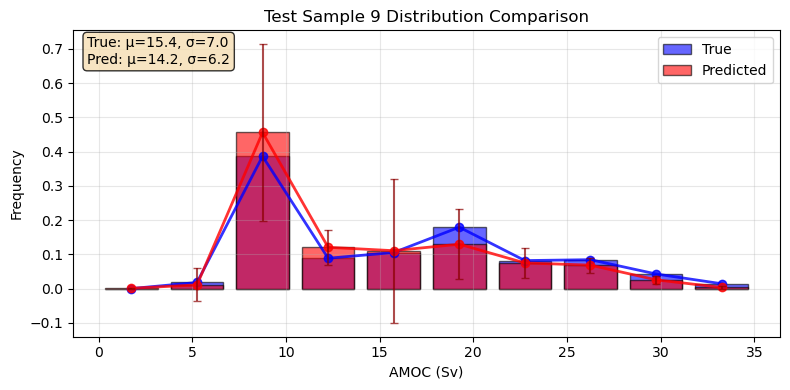

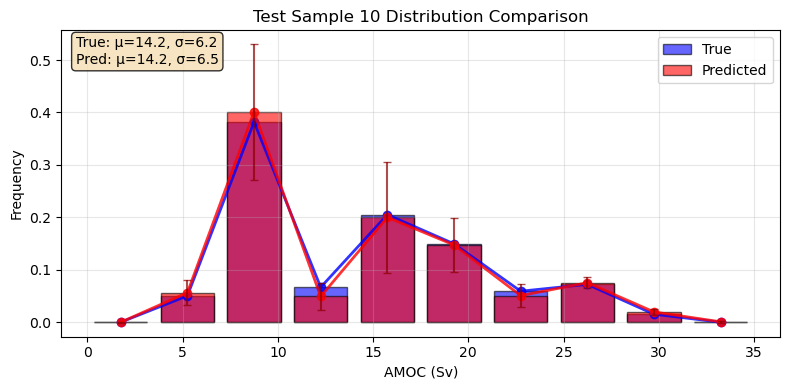


TEST PERFORMANCE
Bin frequencies R²: 0.495
Bin frequencies RMSE: 0.0740

Individual Statistics:
  mean: R² = 0.919, RMSE = 0.5424
  std: R² = 0.629, RMSE = 0.9725
  q25: R² = 0.574, RMSE = 1.6468
  q75: R² = 0.727, RMSE = 1.7150


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1. Prepare data and split
# ----------------------------
X_train, X_test, bin_train, bin_test, Y_train, Y_test = train_test_split(
    X, bin_frequencies, other_stats, test_size=0.2, random_state=100
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# ----------------------------
# 2. Fit emulator on training data
# ----------------------------
kernel = 1 * Matern(length_scale=2.8222222222222224, nu=1.5)
gp_emul = GPEmulatorBins(kernel=kernel)
gp_emul.fit(X_train, Y_train, bin_train)
print("GP emulator fitted on training set.")

# ----------------------------
# 3. Predict on test set
# ----------------------------
bin_pred, Y_pred, bin_std, Y_std = gp_emul.predict(X_test, return_std=True)

# ----------------------------
# 4. Calculate RMSE metrics
# ----------------------------
bin_rmse = np.sqrt(mean_squared_error(bin_test, bin_pred))
print(f"Bin frequencies RMSE: {bin_rmse:.4f}")

stat_names = ['mean', 'std', 'q25', 'q75']
for i, name in enumerate(stat_names):
    rmse = np.sqrt(mean_squared_error(Y_test[:, i], Y_pred[:, i]))
    print(f"{name} RMSE: {rmse:.4f}")

# ----------------------------
# 5. Plot test examples
bins = get_amoc_bins(10)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

# Plot first 3 test examples
for i in range(min(10, len(bin_test))):
    plt.figure(figsize=(8, 4))
    
    # Plot overlapping bars at same x-coordinates
    plt.bar(bin_centers, bin_test[i], width=bin_width*0.8, 
            alpha=0.6, color='blue', label='True', edgecolor='black')
    plt.bar(bin_centers, bin_pred[i], width=bin_width*0.8, 
            alpha=0.6, color='red', label='Predicted', edgecolor='black')
    
    # Add line plots connecting the top centers of each bar type
    plt.plot(bin_centers, bin_test[i], 'o-', color='blue', 
             linewidth=2, markersize=6, alpha=0.8)
    plt.plot(bin_centers, bin_pred[i], 'o-', color='red', 
             linewidth=2, markersize=6, alpha=0.8)
    
    # Add error bars for uncertainty on predicted values
    plt.errorbar(bin_centers, bin_pred[i], yerr=bin_std[i], 
                fmt='none', color='darkred', capsize=3, alpha=0.7, linewidth=1.5)
    
    plt.xlabel('AMOC (Sv)')
    plt.ylabel('Frequency')
    plt.title(f'Test Sample {i+1} Distribution Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Add statistics text
    stats_text = (f"True: μ={Y_test[i,0]:.1f}, σ={Y_test[i,1]:.1f}\n"
                 f"Pred: μ={Y_pred[i,0]:.1f}, σ={Y_pred[i,1]:.1f}")
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# ----------------------------
# 6. Performance summary with separate R² scores
# ----------------------------
print("\n" + "="*40)
print("TEST PERFORMANCE")
print("="*40)

# Bin frequencies
bin_r2 = r2_score(bin_test, bin_pred)
print(f"Bin frequencies R²: {bin_r2:.3f}")
print(f"Bin frequencies RMSE: {bin_rmse:.4f}")

# Individual statistics R² and RMSE
print("\nIndividual Statistics:")
for i, name in enumerate(stat_names):
    r2 = r2_score(Y_test[:, i], Y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(Y_test[:, i], Y_pred[:, i]))
    print(f"  {name}: R² = {r2:.3f}, RMSE = {rmse:.4f}")

In [11]:
def crossvalidation_bins(X, Y, bin_frequencies, emulator_class, emulator_params=None, cv=5,
                        output_names=['mean', 'std', 'q25', 'q75']):
    """
    Cross-validation for bin-based emulator with Matern kernels.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_parameters)
        Input parameters
    Y : array-like, shape (n_samples, n_stats)
        Summary statistics (mean, std, q25, q75)
    bin_frequencies : array-like, shape (n_samples, n_bins)
        Bin frequencies for each sample
    emulator_class : class
        Emulator class (e.g., GPEmulatorBins)
    emulator_params : dict, optional
        Parameters for emulator initialization
    cv : int
        Number of cross-validation folds
    output_names : list
        Names of output statistics
    
    Returns
    -------
    results : dict
        Cross-validation results with mean scores
    """
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    
    if emulator_params is None:
        emulator_params = {}
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=43)
    
    bin_rmses = []
    bin_sup_diffs = []  # Maximum error across all bins
    individual_rmses = {name: [] for name in output_names}
    bin_r2_scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]  
        bins_train, bins_test = bin_frequencies[train_idx], bin_frequencies[test_idx]
        
        # Fit and predict
        emulator = emulator_class(**emulator_params)
        emulator.fit(X_train, Y_train, bins_train)
        bins_pred, Y_pred = emulator.predict(X_test)
        
        # Bin frequency metrics
        bin_rmse = np.sqrt(mean_squared_error(bins_test.flatten(), bins_pred.flatten()))
        bin_rmses.append(bin_rmse)
        
        # Bin supremum difference (max pointwise error across all test samples)
        bin_pointwise_errors = np.abs(bins_test - bins_pred)  # shape: (n_test, n_bins)
        bin_sup_diff = np.max(bin_pointwise_errors)  # maximum error over all bins and test samples
        bin_sup_diffs.append(bin_sup_diff)
        
        # Overall R² score
        per_bin_r2 = [r2_score(bin_test[:, i], bin_pred[:, i]) for i in range(10)]

        #for i, r2 in enumerate(per_bin_r2):
        #    print(f"Bin {i}: R² = {r2:.3f}")
            
        r2score = r2_score(bins_test, bins_pred)
        bin_r2_scores.append(r2score)
        
        # Individual summary statistics RMSEs
        for i, name in enumerate(output_names):
            if i < Y_test.shape[1]:
                rmse = np.sqrt(mean_squared_error(Y_test[:, i], Y_pred[:, i]))
                individual_rmses[name].append(rmse)
    
    # Calculate means across all folds
    results = {
        'bins_rmse': np.mean(bin_rmses),
        'bins_max_error': np.mean(bin_sup_diffs),
        'r2_per_bin': per_bin_r2
    }
    
    # Add individual statistics means
    for name in output_names:
        if len(individual_rmses[name]) > 0:
            results[f'{name}_rmse'] = np.mean(individual_rmses[name])
    
    return results


# Example usage with Matern ν=1.5
from sklearn.gaussian_process.kernels import Matern
import numpy as np

print("Running cross-validation with Matern ν=1.5 kernel...")
print("="*60)

# Use Matern ν=1.5 kernel
kernel = Matern(length_scale=2.8222222222222224, nu=1.5)
emulator_params = {'kernel': kernel}

results = crossvalidation_bins(X, other_stats, bin_frequencies, GPEmulatorBins, 
                              emulator_params=emulator_params, cv=5,
                              output_names=['mean', 'std', 'q25', 'q75'])

print(f"Bins RMSE: {results['bins_rmse']:.4f}")
print(f"Bins Max Error (mean of fold maxima): {results['bins_max_error']:.4f}")
for i, r2 in enumerate(results['r2_per_bin']):
        print(f"Bin {i}: R² = {r2:.3f}")
print("\nIndividual Statistics RMSE:")
for name in ['mean', 'std', 'q25', 'q75']:
    if f'{name}_rmse' in results:
        print(f"  {name}: {results[f'{name}_rmse']:.4f}")

print(f"\n{'='*60}")

Running cross-validation with Matern ν=1.5 kernel...
Bins RMSE: 0.0574
Bins Max Error (mean of fold maxima): 0.3733
Bin 0: R² = -0.456
Bin 1: R² = 0.399
Bin 2: R² = 0.814
Bin 3: R² = 0.128
Bin 4: R² = 0.822
Bin 5: R² = 0.711
Bin 6: R² = 0.456
Bin 7: R² = 0.770
Bin 8: R² = 0.716
Bin 9: R² = 0.589

Individual Statistics RMSE:
  mean: 0.7223
  std: 0.9619
  q25: 1.6803
  q75: 1.8097



In [12]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import Matern, RBF
import numpy as np
import pandas as pd


class EmulatorWrapper(BaseEstimator, RegressorMixin):
    """
    Scikit-learn compatible wrapper for a GP emulator.
    Supports GridSearchCV with varying kernel parameters.
    """

    def __init__(self, emulator_class, kernel_class=Matern, kernel_params=None,
        n_stats=None, **kwargs):
        self.emulator_class = emulator_class
        self.kernel_class = kernel_class
        self.kernel_params = kernel_params  
        self.n_stats = n_stats
        self.kwargs = kwargs

    def fit(self, X, y):
        if self.n_stats is None:
            raise ValueError("n_stats must be provided to split y into Y and bin_frequencies.")
    
        Y = y[:, :self.n_stats]
        bin_frequencies = y[:, self.n_stats:]
        self.bin_frequencies_ = bin_frequencies
    
        # Local replacement for None
        kernel_params = self.kernel_params if self.kernel_params is not None else {}
        kernel = self.kernel_class(**kernel_params)
        self.emulator_ = self.emulator_class(kernel=kernel, **self.kwargs)
    
        print(f"Fitting with kernel: {kernel}")
    
        self.emulator_.fit(X, Y, bin_frequencies)
        return self

    def predict(self, X):
        if self.emulator_ is None:
            raise ValueError("Emulator not fitted yet!")
        return self.emulator_.predict(X)

    def score(self, X, y, alpha=0.5):
        """
        Combined score for GridSearchCV: balances bins and summary stats.
        Higher is better.
        """
        if self.n_stats is None:
            raise ValueError("n_stats must be provided to split y into Y and bin_frequencies.")
    
        # Split y
        Y = y[:, :self.n_stats]
        bin_frequencies = y[:, self.n_stats:]
    
        # Predict
        bins_pred, Y_pred = self.predict(X)
    
        # Normalize RMSE per feature
        rmse_bins = np.sqrt(np.mean((bin_frequencies - bins_pred) ** 2, axis=0))
        rmse_bins_norm = rmse_bins / (np.std(bin_frequencies, axis=0) + 1e-12)
        rmse_bins_score = 1 - np.mean(rmse_bins_norm)
    
        rmse_stats = np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0))
        rmse_stats_norm = rmse_stats / (np.std(Y, axis=0) + 1e-12)
        rmse_stats_score = 1 - np.mean(rmse_stats_norm)
    
        # Combine
        combined_score = alpha * rmse_bins_score + (1 - alpha) * rmse_stats_score
    
        print("rmse_bins_score:", rmse_bins_score)
        print("rmse_stats_score:", rmse_stats_score)
        print("combined_score:", combined_score)
    
        return -np.mean(rmse_bins)



# ----------------------
# Helper functions
# ----------------------
def prepare_data_for_gridsearch(X, Y, bin_frequencies):
    return X, np.hstack((Y, bin_frequencies))


def tune_emulator_hyperparameters(X, Y, bin_frequencies, emulator_class,
                                   param_grid, cv=5, verbose=2, n_jobs=-1):
    X_data, y_data = prepare_data_for_gridsearch(X, Y, bin_frequencies)
    print(f"Training data shapes: X={X_data.shape}, y={y_data.shape}")

    wrapper = EmulatorWrapper(
        emulator_class=emulator_class,
        n_stats=Y.shape[1]
    )

    grid_search = GridSearchCV(
        estimator=wrapper,
        param_grid=param_grid,
        cv=cv,
        scoring=None,
        verbose=verbose,
        n_jobs=n_jobs,
        refit=True
    )

    grid_search.fit(X_data, y_data)
    return grid_search


# ----------------------
# Example usage
# ----------------------
tune_gp=False
if tune_gp:
    # Example random data (replace with your real data)
    # Grid search param grid
        # Length scales from 0.1 to 5.0 (10 evenly spaced values)
    length_scales = np.linspace(0.1, 5.0, 10)
    
    # nu values for Matern
    nus = [0.5, 1.5, 2.5]
    
    # Build param grid automatically
    param_grid = [
        {
            'kernel_class': [Matern],
            'kernel_params': [{'nu': nu, 'length_scale': ls} for nu in nus for ls in length_scales]
        },
        {
            'kernel_class': [RBF],
            'kernel_params': [{'length_scale': ls} for ls in length_scales]
        }
    ]

    print("Running GridSearchCV for hyperparameter tuning...")
    print("=" * 70)

    Y = other_stats
    print("X shape:", X.shape)
    print("Y shape:", Y.shape)
    print("bin_frequencies shape:", bin_frequencies.shape)


    grid_search = tune_emulator_hyperparameters(
        X, Y, bin_frequencies,
        GPEmulatorBins,
        param_grid=param_grid,
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    print("\n" + "=" * 70)
    print("BEST PARAMETERS:")
    for key, val in grid_search.best_params_.items():
        print(f"  {key}: {val}")

    print(f"\nBest Score: {grid_search.best_score_:.6f}")
    #print(f"Best RMSE: {-grid_search.best_score_:.6f}")

    # Top 5 configurations
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = results_df.sort_values('rank_test_score')

    print("\nTop 5 configurations:")
    for i, (idx, row) in enumerate(results_df.head(5).iterrows(), 1):
        print(f"{i}. Params: {row['params']}")
        print(f"   Mean Score: {row['mean_test_score']:.6f} (RMSE: {-row['mean_test_score']:.6f})")
        print(f"   Std Score: {row['std_test_score']:.6f}")


# ABC parameter estimation with GP emulator

In [13]:
import numpy as np

class ABCBins:
    def __init__(self, emulator, bins_default, stats_default,
                 std_tol=0.5, bin_tol=0.05, prior_sampler=None):
        """
        Approximate Bayesian Computation for GPEmulatorBins.

        Parameters
        ----------
        emulator : GPEmulatorBins (trained)
            Emulator mapping parameters -> (bins, stats).
        bins_obs : array, shape (n_bins,)
            Observed bin frequencies to match.
        stats_obs : array, shape (n_stats,)
            Observed summary stats (mean, std, ...).
        std_tol : float
            Maximum allowed absolute difference in std.
        bin_tol : float
            Maximum allowed absolute difference in any bin.
        prior_sampler : callable
            Function returning a random parameter vector from the prior.
        """
        self.emulator = emulator
        self.bins_default = np.asarray(bins_default).flatten()
        self.stats_default = np.asarray(stats_default).flatten()
        self.std_tol = std_tol
        self.bin_tol = bin_tol
        self.prior_sampler = prior_sampler

    def _distance_checks(self, theta):
        
        theta = np.array(theta).reshape(1, -1)
        pred_bins, pred_stats = self.emulator.predict(theta, return_std=False)
    
        std_diff = np.abs(pred_stats.flatten()[1] - self.stats_default[1])

        bin_max_diff = np.max(np.abs(pred_bins - self.bins_default))
        
        return std_diff, bin_max_diff


    def sample(self, n_samples=1000, max_iter=10000):
        """
        Run ABC rejection sampling.

        Returns
        -------
        accepted : array, shape (n_accepted, n_parameters)
            Accepted parameter sets.
        """
        if self.prior_sampler is None:
            raise ValueError("Please provide a prior_sampler when creating ABCBins.")
        
        accepted = []
        for _ in range(max_iter):
            theta = self.prior_sampler()
            std_diff, bin_max_diff = self._distance_checks(theta)

            if (std_diff < self.std_tol) and (bin_max_diff < self.bin_tol):
                accepted.append(theta)

            if len(accepted) >= n_samples:
                break

        return np.array(accepted)


In [14]:
prior_bounds = {
    "diff_dia_min": (7.5e-6, 1.25e-5),
    "drag_topo_fac": (2.25, 3.75),
    "slope_max": (7.5e-4, 1.25e-3),
    "diff_iso": (1125, 1875),
    "diff_gm": (1125, 1875),
    "diff_dia_max": (1.125e-4, 1.875e-4),
}

In [15]:
kernel = 1.0 * Matern(length_scale=3.366666666666667, nu=1.5)
gp_emulator = GPEmulatorBins(kernel=kernel)

# Fit on full dataset
gp_emulator.fit(X, other_stats, bin_frequencies)
print("GP Emulator trained on full dataset.")

# Observed summaries from default run
bins_default = default_stats['bin_frequencies']   # shape (n_bins,)

stats_default = np.array([
    default_stats['mean'],
    default_stats['std'],
    default_stats['q25'],
    default_stats['q75']
])

run_ABC = False
if run_ABC:
    # -----------------------------
    # 2. Define prior sampler
    # -----------------------------
    
    def prior_sampler():
        return np.array([
            np.random.uniform(*prior_bounds["diff_dia_min"]),
            np.random.uniform(*prior_bounds["drag_topo_fac"]),
            np.random.uniform(*prior_bounds["slope_max"]),
            np.random.uniform(*prior_bounds["diff_iso"]),
            np.random.uniform(*prior_bounds["diff_gm"]),
            np.random.uniform(*prior_bounds["diff_dia_max"]),
        ])
    np.random.seed(42)  # for reproducibility
    abc = ABCBins(
        emulator=gp_emulator,
        bins_default=bins_default,
        stats_default=stats_default,
        std_tol=0.08,
        bin_tol=0.01,
        prior_sampler=prior_sampler
    )
    
    accepted_params = abc.sample(n_samples=100000, max_iter=100000000)
    print(f"Accepted {accepted_params.shape[0]} parameter sets")


GP Emulator trained on full dataset.


In [16]:
#np.save('accepted_params.npy', accepted_params)
accepted_params = np.load('accepted_params.npy')
print(accepted_params[:10])

[[1.09996968e-05 3.17427495e+00 1.10317070e-03 1.72671569e+03
  1.52599125e+03 1.42491503e-04]
 [1.03702081e-05 3.06701787e+00 1.16892845e-03 1.66482282e+03
  1.49925396e+03 1.52722474e-04]
 [8.26413865e-06 3.58553307e+00 7.88766504e-04 1.69147651e+03
  1.14467963e+03 1.54323090e-04]
 [1.00093627e-05 2.96855517e+00 1.18006192e-03 1.62257489e+03
  1.49533829e+03 1.51006687e-04]
 [9.91420716e-06 3.05088969e+00 1.15328919e-03 1.66229156e+03
  1.45367810e+03 1.51075126e-04]
 [1.04153899e-05 3.17020669e+00 1.08709715e-03 1.73099377e+03
  1.43913828e+03 1.45116771e-04]
 [1.09916902e-05 3.02614135e+00 1.13640438e-03 1.52171808e+03
  1.51138545e+03 1.48657738e-04]
 [1.12704115e-05 3.23864624e+00 1.09888075e-03 1.69389959e+03
  1.43010944e+03 1.42050137e-04]
 [1.05306950e-05 3.16802752e+00 1.11611427e-03 1.68329252e+03
  1.42755553e+03 1.47440662e-04]
 [8.59172689e-06 2.89366776e+00 1.04780179e-03 1.31347666e+03
  1.30689997e+03 1.58799634e-04]]


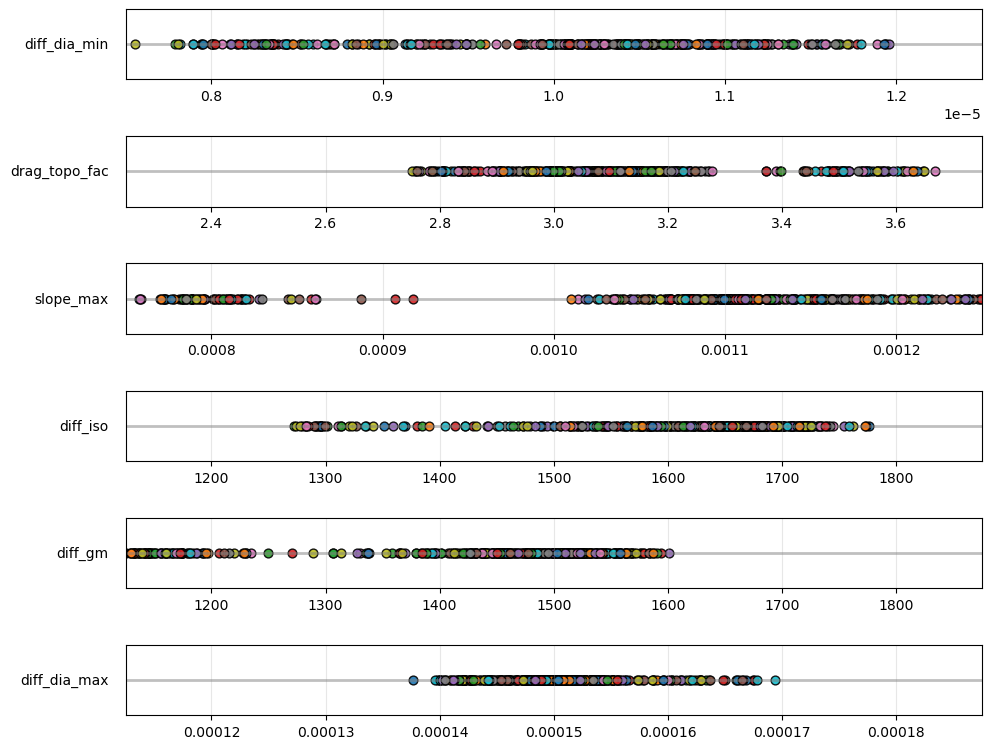

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# -------------------------------------------------------
# Example setup (replace with your real arrays)
# -------------------------------------------------------
param_names = ["diff_dia_min", "drag_topo_fac", "slope_max",
               "diff_iso", "diff_gm", "diff_dia_max"]

bounds = np.array([prior_bounds[p] for p in param_names])   # shape (6, 2)
accepted = np.array(accepted_params)                        # (n_sets, 6)
n_params = len(param_names)
n_sets = accepted.shape[0]

# Use matplotlib’s standard color cycle (blue, orange, green, red, …)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = list(itertools.islice(itertools.cycle(default_colors), n_sets))

# -------------------------------------------------------
# Plot
# -------------------------------------------------------
fig, axes = plt.subplots(n_params, 1, figsize=(10, 8), sharex=False)

for j, ax in enumerate(axes):
    lb, ub = bounds[j]
    ax.set_xlim(lb, ub)
    ax.set_ylabel(param_names[j], rotation=0, ha='right', va='center')
    ax.yaxis.set_label_coords(-0.02, 0.5)
    ax.set_yticks([])  # no y ticks
    ax.grid(axis='x', alpha=0.3)

    # horizontal line for prior bounds
    ax.hlines(y=0, xmin=lb, xmax=ub, color='gray', lw=2, alpha=0.5)

    # dots for accepted values (same color per combination)
    for k in range(n_sets):
        ax.scatter(accepted[k, j], 0,
                   color=color_cycle[k],
                   s=40, edgecolor='k', alpha=0.9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


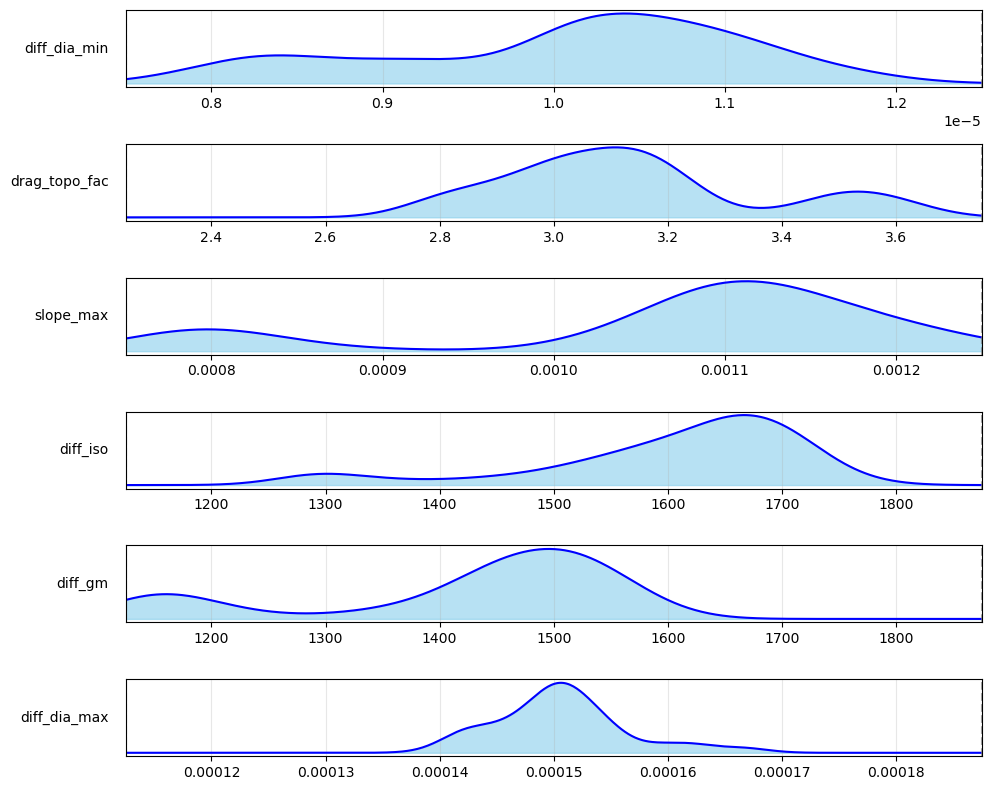

In [18]:
accepted = np.array(accepted_params)                        # (n_sets, 6)
n_params = len(param_names)

# -------------------------------------------------------
# Plot KDE for parameter distributions using Matplotlib + scipy
# -------------------------------------------------------
fig, axes = plt.subplots(n_params, 1, figsize=(10, 8), sharex=False)

for j, ax in enumerate(axes):
    lb, ub = bounds[j]
    data = accepted[:, j]

    # Compute KDE
    kde = gaussian_kde(data)
    x_vals = np.linspace(lb, ub, 500)
    y_vals = kde(x_vals)

    ax.fill_between(x_vals, 0, y_vals, color='skyblue', alpha=0.6)
    ax.plot(x_vals, y_vals, color='blue')

    # prior bounds lines
    ax.axvline(lb, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(ub, color='gray', linestyle='--', alpha=0.7)

    ax.set_xlim(lb, ub)
    ax.set_ylabel(param_names[j], rotation=0, ha='right', va='center')
    ax.yaxis.set_label_coords(-0.02, 0.5)
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


# MCMC

In [25]:
import emcee

# -----------------------------
# 1. Prior bounds (6 parameters)
# -----------------------------
prior_bounds = {
    "diff_dia_min": (7.5e-6, 1.25e-5),
    "drag_topo_fac": (2.25, 3.75),
    "slope_max": (7.5e-4, 1.25e-3),
    "diff_iso": (1125, 1875),
    "diff_gm": (1125, 1875),
    "diff_dia_max": (1.125e-4, 1.875e-4),
}

param_names = list(prior_bounds.keys())
lower_bounds = np.array([b[0] for b in prior_bounds.values()])
upper_bounds = np.array([b[1] for b in prior_bounds.values()])
ndim = len(param_names)

def log_prior(theta):
    theta = np.asarray(theta)
    if np.all((theta >= lower_bounds) & (theta <= upper_bounds)):
        return 0.0
    return -np.inf

# -----------------------------
# 2. Log-likelihood: bins + std
# -----------------------------
sigma_bins = 0.01   # close to your previous bin_tol
sigma_std = 0.08    # close to your previous std_tol

def log_likelihood(theta):
    theta = np.array(theta).reshape(1, -1)
    pred_bins, pred_stats = gp_emulator.predict(theta, return_std=False)
    pred_bins = pred_bins.flatten()
    pred_stats = pred_stats.flatten()
    
    # Gaussian discrepancy for bins
    bin_term = -0.5 * np.sum((bins_default - pred_bins)**2) / sigma_bins**2
    
    # Gaussian discrepancy for standard deviation
    std_term = -0.5 * (pred_stats[1] - stats_default[1])**2 / sigma_std**2
    
    return bin_term + std_term

# -----------------------------
# 3. Posterior function
# -----------------------------
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# -----------------------------
# 4. Initialize walkers
# -----------------------------
nwalkers = 32
initial_pos = lower_bounds + (upper_bounds - lower_bounds) * np.random.rand(nwalkers, ndim)

# -----------------------------
# 5. Run MCMC
# -----------------------------
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
n_steps = 5000
sampler.run_mcmc(initial_pos, n_steps, progress=True)

# -----------------------------
# 6. Extract posterior samples
# -----------------------------
burn_in = 1000
thin = 10
posterior_samples = sampler.get_chain(discard=burn_in, thin=thin, flat=True)

print(f"Posterior samples shape: {posterior_samples.shape}")


100%|██████████████████████████████████████| 5000/5000 [00:19<00:00, 252.01it/s]

Posterior samples shape: (12800, 6)


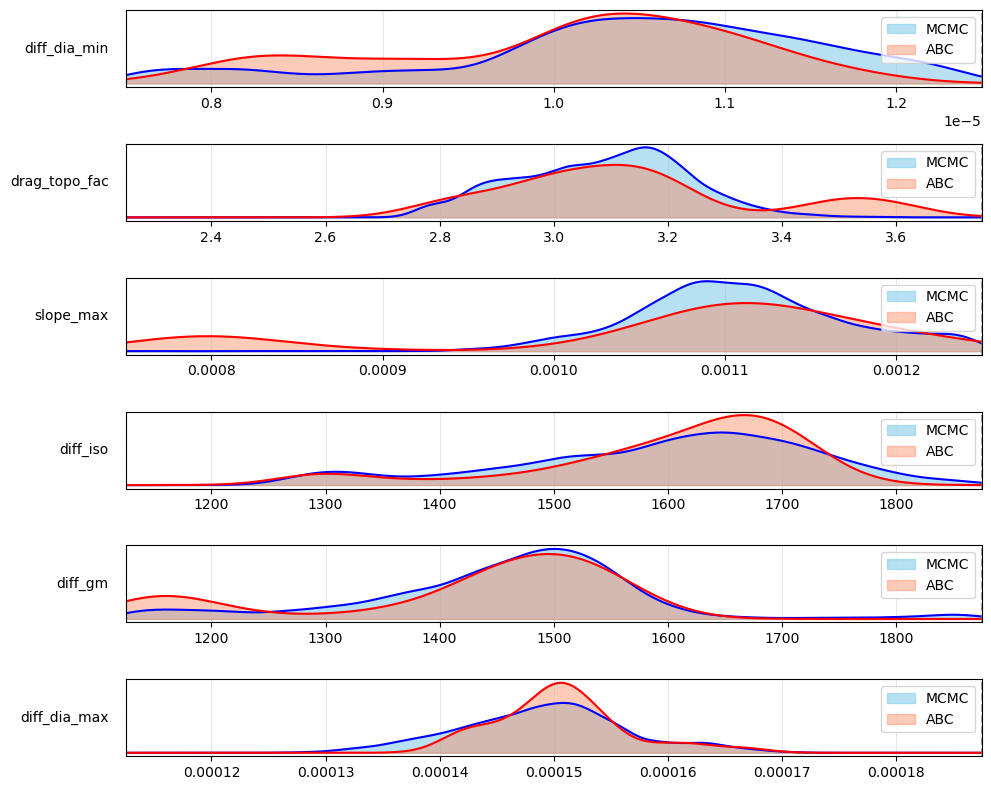

In [26]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# posterior_samples: shape (n_samples, 6) from MCMC
# accepted_params: shape (n_sets, 6) from ABC
n_params = len(param_names)
bounds = [prior_bounds[name] for name in param_names]

fig, axes = plt.subplots(n_params, 1, figsize=(10, 8), sharex=False)

for j, ax in enumerate(axes):
    lb, ub = bounds[j]

    # -----------------------------
    # KDE for MCMC posterior
    # -----------------------------
    data_mcmc = posterior_samples[:, j]
    kde_mcmc = gaussian_kde(data_mcmc)
    x_vals = np.linspace(lb, ub, 500)
    y_vals_mcmc = kde_mcmc(x_vals)
    ax.fill_between(x_vals, 0, y_vals_mcmc, color='skyblue', alpha=0.6, label='MCMC')
    ax.plot(x_vals, y_vals_mcmc, color='blue')

    # -----------------------------
    # KDE for ABC accepted samples
    # -----------------------------
    abc = True
    if abc: 
        data_abc = accepted_params[:, j]
        if len(data_abc) > 0:
            kde_abc = gaussian_kde(data_abc)
            y_vals_abc = kde_abc(x_vals)
            ax.fill_between(x_vals, 0, y_vals_abc, color='coral', alpha=0.4, label='ABC')
            ax.plot(x_vals, y_vals_abc, color='red')

    # prior bounds
    ax.axvline(lb, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(ub, color='gray', linestyle='--', alpha=0.7)

    # axis labels
    ax.set_xlim(lb, ub)
    ax.set_ylabel(param_names[j], rotation=0, ha='right', va='center')
    ax.yaxis.set_label_coords(-0.02, 0.5)
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.3)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [21]:
import numpy as np

save_params = False

if save_params:
    # Parameter names in the correct order
    param_names = ["ocn.diff_dia_min", "ocn.drag_topo_fac", "ocn.slope_max",
                   "ocn.diff_iso", "ocn.diff_gm", "ocn.diff_dia_max"]
    
    # Randomly select 50 accepted parameter sets (without replacement)
    n_save = min(50, len(accepted_params))
    random_idx = np.random.choice(len(accepted_params), size=n_save, replace=False)
    chosen_params = accepted_params[random_idx]
    
    # Save to text file
    out_file = "chosen_params.txt"
    with open(out_file, "w") as f:
        # Write header
        f.write(" ".join(param_names) + "\n")
        # Write parameter rows
        for row in chosen_params:
            f.write(" ".join(f"{val:.17g}" for val in row) + "\n")
    
    print(f"Saved {n_save} parameter sets to {out_file}")
